## EDA

In [1]:
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from bayes_opt import BayesianOptimization
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product

from IPython.display import HTML

In [2]:
folder_path = 'data/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')
# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [22]:
train_transaction[train_transaction.isFraud == 1].head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
203,2987203,1,89760,445.000,W,18268,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,2987240,1,90193,37.098,C,13413,103.0,185.0,visa,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,2987243,1,90246,37.098,C,13413,103.0,185.0,visa,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2987245,1,90295,37.098,C,13413,103.0,185.0,visa,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,2987288,1,90986,155.521,C,16578,545.0,185.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for col, values in train_transaction[train_transaction.isFraud == 1].iteritems():
    num_uniques = values.nunique()
    print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
    print (values.unique())
    print ('\n')

In [ ]:
pd.options.display.max_rows = 400
train_transaction[train_transaction.isFraud == 1].iloc[33]

## Simple XGB

In [3]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [4]:
train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)

In [5]:
test.columns

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)

In [23]:
y_train = train.isFraud
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

In [16]:
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)
# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

NameError: name 'X_train' is not defined

In [25]:
del train, test

In [10]:
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    nthread=10
    #tree_method='gpu_hist'  # THE MAGICAL PARAMETER
)

In [11]:
%time clf.fit(X_train, y_train)

CPU times: user 2h 26min 58s, sys: 6min 24s, total: 2h 33min 22s
Wall time: 19min 22s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=-999, n_estimators=500, n_jobs=1,
       nthread=10, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

In [13]:
sample_submission = pd.read_csv(f'{folder_path}sample_submission.csv', index_col='TransactionID')

In [14]:
sample_submission = pd.read_csv(f'{folder_path}sample_submission.csv', index_col='TransactionID')
sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]
sample_submission.to_csv('simple_xgboost_gpu.csv')

## LGBM with Bayes Opt

In [3]:
#  Libraries
import numpy as np 
import pandas as pd 
# Data processing, metrics and modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold
from bayes_opt import BayesianOptimization
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from sklearn import metrics
from sklearn import preprocessing
# Lgbm
import lightgbm as lgb
# Suppr warning
import warnings
warnings.filterwarnings("ignore")

import itertools
from scipy import interp

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

In [4]:
features = list(train)
features.remove('isFraud')
target = 'isFraud'

In [5]:
train = train.fillna(-999)
test = test.fillna(-999)
for f in features:
    if train[f].dtype=='object' or test[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))


In [6]:
#cut tr and val
bayesian_tr_idx, bayesian_val_idx = train_test_split(train, test_size = 0.3, random_state = 87, stratify = train[target])
bayesian_tr_idx = bayesian_tr_idx.index
bayesian_val_idx = bayesian_val_idx.index

In [17]:
def LGB_bayesian(
    #learning_rate,
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_samples, 
    min_child_weight,
    subsample, 
    min_data_in_leaf,
    max_depth,
    colsample_bytree,
    reg_alpha,
    reg_lambda
     ):
    
    # LightGBM expects next three parameters need to be integer. 
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    

    param = {
              'num_leaves': num_leaves, 
              'min_child_samples': min_child_samples, 
              'min_data_in_leaf': min_data_in_leaf,
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              #'learning_rate' : learning_rate,
              'subsample': subsample, 
              'max_depth': max_depth,
              'colsample_bytree': colsample_bytree,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'objective': 'binary',
              'save_binary': True,
              'seed': 1337,
              'feature_fraction_seed': 1337,
              'bagging_seed': 1337,
              'drop_seed': 1337,
              'data_random_seed': 1337,
              'boosting_type': 'gbdt',
              'verbose': 1,
              'is_unbalance': False,
              'boost_from_average': True,
              'metric':'auc'}    
    
    oof = np.zeros(len(train))
    trn_data= lgb.Dataset(train.iloc[bayesian_tr_idx][features].values, label=train.iloc[bayesian_tr_idx][target].values)
    val_data= lgb.Dataset(train.iloc[bayesian_val_idx][features].values, label=train.iloc[bayesian_val_idx][target].values)

    clf = lgb.train(param, trn_data,  num_boost_round=50, valid_sets = [trn_data, val_data], verbose_eval=0, early_stopping_rounds = 50)
    
    oof[bayesian_val_idx]  = clf.predict(train.iloc[bayesian_val_idx][features].values, num_iteration=clf.best_iteration)  
    
    score = roc_auc_score(train.iloc[bayesian_val_idx][target].values, oof[bayesian_val_idx])

    return score

In [7]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (31, 500), 
    'min_data_in_leaf': (20, 200),
    'bagging_fraction' : (0.1,0.9),
    'feature_fraction' : (0.1,0.9),
    #'learning_rate': (0.01, 0.3),
    'min_child_weight': (0.00001, 0.01),   
    'min_child_samples':(100, 500), 
    'subsample': (0.2, 0.8),
    'colsample_bytree': (0.4, 0.6), 
    'reg_alpha': (1, 2), 
    'reg_lambda': (1, 2),
    'max_depth':(-1,50),
}

In [19]:
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=87)

In [20]:
print(LGB_BO.space.keys)

['bagging_fraction', 'colsample_bytree', 'feature_fraction', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_data_in_leaf', 'num_leaves', 'reg_alpha', 'reg_lambda', 'subsample']


In [21]:
init_points = 10
n_iter = 15

In [22]:
print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | colsam... | featur... | max_depth | min_ch... | min_ch... | min_da... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8785   |  0.625    |  0.591    |  0.8767   |  3.989    |  196.3    |  0.008688 |  118.5    |  368.3    |  1.926    |  1.617    |  0.6001   |
|  2        |  0.9514   |  0.3671   |  0.4366   |  0.39     |  19.49    |  404.8    |  0.002675 |  68.08    |  488.8    |  1.062    |  1.419    |  0.4107   |
|  3        |  0.9433   |  0.1716   |  0.4395   |  0.8527   | -0.4612   |  174.4    |  0.009855 |  81.25    |  184.1    |  1.654    |  1.022    |  0.3152   |
|  4        |  0.9448   |  0.862    |  0.5501   |  0.2816   |  31.53    |  112.

In [23]:
LGB_BO.max['target']

0.9561561314254349

In [24]:
LGB_BO.max['params']

{'bagging_fraction': 0.2548043210587658,
 'colsample_bytree': 0.5579195650937059,
 'feature_fraction': 0.6907660980289639,
 'max_depth': 45.83366459783808,
 'min_child_samples': 299.06472700672117,
 'min_child_weight': 0.0031778570175284566,
 'min_data_in_leaf': 21.427642007695642,
 'num_leaves': 490.15525281823756,
 'reg_alpha': 1.6083331773049245,
 'reg_lambda': 1.143573447284028,
 'subsample': 0.7539309525325935}

In [6]:
param_lgb = {
        'min_data_in_leaf': int(21.427642007695642), 
        'num_leaves': int(490.15525281823756), 
        #'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_child_weight': 0.0031778570175284566,
        'colsample_bytree' : 0.5579195650937059,
        'bagging_fraction': 0.2548043210587658, 
        'min_child_samples': 299.06472700672117,
        'subsample': 0.7539309525325935,
        'reg_lambda': 1.143573447284028,
        'reg_alpha': 1.6083331773049245,
        'max_depth': 46, 
        'objective': 'binary',
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'boosting_type': 'gbdt',
        'verbose': 1,
        'is_unbalance': False,
        'boost_from_average': True,
        'metric':'auc'
    }

In [25]:
param_lgb = {
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']), 
        'num_leaves': int(LGB_BO.max['params']['num_leaves']), 
        #'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_child_weight': LGB_BO.max['params']['min_child_weight'],
        'colsample_bytree' : LGB_BO.max['params']['colsample_bytree'],
        'bagging_fraction': LGB_BO.max['params']['bagging_fraction'], 
        'min_child_samples': LGB_BO.max['params']['min_child_samples'],
        'subsample': LGB_BO.max['params']['subsample'],
        'reg_lambda': LGB_BO.max['params']['reg_lambda'],
        'reg_alpha': LGB_BO.max['params']['reg_alpha'],
        'max_depth': int(LGB_BO.max['params']['max_depth']), 
        'objective': 'binary',
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'boosting_type': 'gbdt',
        'verbose': 1,
        'is_unbalance': False,
        'boost_from_average': True,
        'metric':'auc'
    }


fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.997069	valid_1's auc: 0.967797
[200]	training's auc: 0.999795	valid_1's auc: 0.971479
[300]	training's auc: 0.99999	valid_1's auc: 0.972181
[400]	training's auc: 0.999999	valid_1's auc: 0.972107
Early stopping, best iteration is:
[310]	training's auc: 0.999993	valid_1's auc: 0.972276

fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.997001	valid_1's auc: 0.966895
[200]	training's auc: 0.999833	valid_1's auc: 0.971771
[300]	training's auc: 0.999993	valid_1's auc: 0.972419
[400]	training's auc: 1	valid_1's auc: 0.97246
Early stopping, best iteration is:
[310]	training's auc: 0.999995	valid_1's auc: 0.972483

fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.997111	valid_1's auc: 0.968182
[200]	training's auc: 0.999839	valid_1's auc: 0.972384
[300]	training's auc: 0.999992	valid_1's auc: 0.97264
[400]	traini

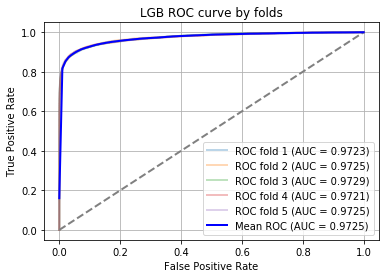

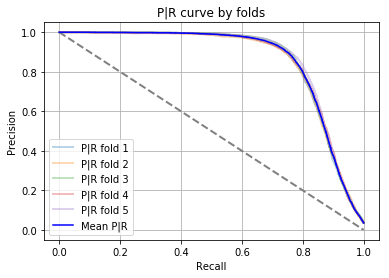

In [7]:
plt.rcParams["axes.grid"] = True

nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(len(train))
mean_fpr = np.linspace(0,1,100)
cms= []
tprs = []
aucs = []
y_real = []
y_proba = []
recalls = []
roc_aucs = []
f1_scores = []
accuracies = []
precisions = []
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

i = 1
for train_idx, valid_idx in skf.split(train, train.isFraud.values):
    print("\nfold {}".format(i))
    trn_data = lgb.Dataset(train.iloc[train_idx][features].values,
                                   label=train.iloc[train_idx][target].values
                                   )
    val_data = lgb.Dataset(train.iloc[valid_idx][features].values,
                                   label=train.iloc[valid_idx][target].values
                                   )   
    
    clf = lgb.train(param_lgb, trn_data, num_boost_round = 500, valid_sets = [trn_data, val_data], verbose_eval = 100, early_stopping_rounds = 100)
    oof[valid_idx] = clf.predict(train.iloc[valid_idx][features].values) 
    
    predictions += clf.predict(test[features]) / nfold
    
    # Scores 
    roc_aucs.append(roc_auc_score(train.iloc[valid_idx][target].values, oof[valid_idx]))
    accuracies.append(accuracy_score(train.iloc[valid_idx][target].values, oof[valid_idx].round()))
    recalls.append(recall_score(train.iloc[valid_idx][target].values, oof[valid_idx].round()))
    precisions.append(precision_score(train.iloc[valid_idx][target].values ,oof[valid_idx].round()))
    f1_scores.append(f1_score(train.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Roc curve by folds
    f = plt.figure(1)
    fpr, tpr, t = roc_curve(train.iloc[valid_idx][target].values, oof[valid_idx])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))
    
    # Precion recall by folds
    g = plt.figure(2)
    precision, recall, _ = precision_recall_curve(train.iloc[valid_idx][target].values, oof[valid_idx])
    y_real.append(train.iloc[valid_idx][target].values)
    y_proba.append(oof[valid_idx])
    plt.plot(recall, precision, lw=2, alpha=0.3, label='P|R fold %d' % (i))  
    
    i= i+1
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(train.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Features imp
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = nfold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# Metrics
print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores))
)

#ROC 
f = plt.figure(1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_aucs)),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGB ROC curve by folds')
plt.legend(loc="lower right")

# PR plt
g = plt.figure(2)
plt.plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
plt.plot(recall, precision, color='blue',
         label=r'Mean P|R')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('P|R curve by folds')
plt.legend(loc="lower left")

In [8]:
predictions

array([0.00048491, 0.0003801 , 0.00085444, ..., 0.0009524 , 0.00132926,
       0.0020493 ])

In [9]:
sample_submission = pd.read_csv(f'{folder_path}sample_submission.csv', index_col='TransactionID')
sample_submission['isFraud'] = predictions
sample_submission.to_csv('xbg_bayes_opt.csv')